# Tutorial 4: Integrating Chemical Master Equations 

© 2018 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cbbtn_utilities as cb
sns.set_context('talk')
sns.set()
%matplotlib inline

In this tutorial, we will use the Forward Euler method of numerical integration to explore diffusion in several contexts, and tie it to the experimental technique of fluorescence recovery after photobleaching. 

# Another View of Diffusion: The Chemical Master Equation

As we have seen over and over again, diffusion is a central concept in our understanding of how life operates. The principles of diffusion can shed light on how molecules travel within cells and organisms, to herd migration, to changing of allele frequencies over time. In this course, we've examined the case of a one-dimensional random walk and its connection to diffusion in an earlier tutorial where we performed repeated trials of coin flips to get a picture of the probability distribution of position as a function of time.

Rather than relying on our computer to flip a seemingly infinite number of coins, we can compute the distribution deterministically using something called a chemical master equation. In this approach we consider all of the possible ways particles can move in a discretized system at very small time steps and keeping track of either the number of particles around or the probability of being at that position at a specific time.

Let's be more explicit and draw some cartoons. Let's imagine that we live in a one-dimensional world. Along this dimension, we have a string of boxes of a width a=1
which can either be empty or contain a particle. At any point in time, a given particle can move to either the left or right at some rate k, which we'll call the jump frequency, or it can stay put. A cartoon of these trajectories and their weights is shown below.

![](jump_trajectory.png)

These weights can be used to formulate our master equation. We simply have to say, given the probability $p$ of a particle being at position $x$ at time $t$, what's the probability at time $t+\Delta t$ knowing the jump frequency $k$. We'll have to keep track of the movement of particles from our box of interest as well as the movement of particles from the boxes on the left and right into our box. Mathematically, this is written as

$$
p(x, t + \Delta t) = \overbrace{p(x,t)}^{\text{starting probability}} + \underbrace{(k\Delta t p(x - a, t)}_\text{jump from left} + \underbrace{k\Delta t p(x + a, t)}_\text{jump from right} - \overbrace{2 k\Delta t p(x, t)}^\text{jump to right or left}. \tag{1}
$$

Because we now have the superpower of scientific programming, we can write a few lines of code to integrate this equation over a period of time and keep track of all of the probabilities.

##  A Refresher On Numerical Integration
At the beginning of the course, you learned how to write a program to perform a Forward-Euler integration of a ordinary differential equation (see [tutorial 1](t1a_numerical_integration.html) for a reminder). We'll be performing essentially the same procedure to evaluate Eq. 1, but we have a few peculiarities of this approach that we'll have to keep in the back of our mind.

Firstly, unlike our exploration of exponential growth, we will be integrating over time as well as over *position*. This means that we will have set up an array where we can store the computed probability of finding a particle in each box over a range of time points.

Secondly, we have to be wary of the boundary conditions. Since we are solving this numerically on our computers, we can't have a truly infinite number of boxes. This means that we will have to be a little careful of how we compute the probabilities at the edges. For example, if we are computing the probability in our first box, we know that the particle can only jump into the box to the right, or stay put. You can think of this box being against a wall where things can't pass through. Likewise, we have the same condition in the final box where particles can only jump to the left or stay put.

For example, let's say that we are thinking of a system with only ten boxes. Our boundary condition for the first box (box 1), would be

$$
p(x=1, t + \Delta t) =  p(x = 1, t) + k\Delta t p(x =2, t) - k\Delta t p(x=1, t). \tag{2}
$$

Similarly, for our final box ($x = 10$), our master equation is

$$
p(x=10, t + \Delta t) = p(x = 10, t) + k\Delta tp(x=9, t) - k \Delta t p(x=10, t). \tag{3}
$$

Knowing these two requirements, we can write a general function for our master equation for any number of boxes and time points.

In [5]:
def master_equation(prob, k, dt):
    """
    Computes the master equation for diffusion in one dimension.
    
    Parameters
    ----------
    prob : 2d-array
        Array in which the probabiilities will be stored. This should be in
        the shape of N boxes by m time points. This should have a preset initial
        condition. 
    k : float
        Jump rate of particles between boxes in units of 1/s. 
    dt : float
        Time step for our integration. This should be in units of seconds and
        should be sufficiently smaller than our jump rate for numerical stability.
        
    Returns
    -------
    prob: 2d-array
        The probability vector given to the function where each element now
        contains a computed probability.
    """
    
    # We'll first figure out the total number of boxes and the number 
    # of time steps we will integrate over. This will essentially be the
    # shape of our prob array. 
    num_boxes, time_points = np.shape(prob)
    
    # We need to integrate over each time step. Since we have the initial 
    # condition  set, we can start at time step '2' which is 1 in Python. 
    for t in range(1, time_points): 
        # Now we will need to deal with the boundary conditions. If we are 
        # at box 0, we can't deal with box -1. Likewise, if we are in the
        # final box, we can't deal with box +1. There are more clever 
        # ways we could deal with this, but for right now we can just compute
        # these two cases explicity. 
        prob[0, t] = prob[0, t-1] + k * dt * prob[1, t-1] - k * dt * prob[0, t-1]
       
        # Identify the index of the last box.
        last_box = num_boxes - 1
        prob[last_box, t] = prob[last_box, t-1] + \
                                k * dt * prob[last_box-1, t-1] -\
                                k * dt * prob[last_box, t-1]
                
        # With the boundary conditions in place, we can now iterate over 
        # all other boxes and repeat this procedure. 
        for box in range(1, num_boxes - 1):
            prob[box, t] = prob[box, t-1] + k * dt * prob[box-1, t-1] +\
                           k * dt * prob[box+1, t-1] -\
                           2 * k * dt * prob[box, t-1]
                
    # Now we've integrated over all time steps for each box and can just 
    # return our array
    return prob

Now that we have our function in place, let's test it out. We'll think of a very simple case in which we have a very long string of boxes which are all empty, except for one right in the middle which will have an initial probability $p(x=\text{middle},t=0)=1.0$. You can think of this as adding a pulse of dye molecules within the cell cytoplasm or some carbon atoms in iron in the making of steel. We will expect that as time goes on, we'll watch the concentration profile broaden. We'll start by defining our parameters.

In [6]:
# Define the parameters. 
k = 5  # Jump  frequency in inverse seconds. 
dt = 1 / 50  # Time step sufficiently smaller than the jump frequency.
num_boxes = 80  # The total number of boxes 
time_steps = 100  # Total time of the integration in units of seconds. 

Here, I've taken the liberty of setting our time step to something much smaller than our jump rate. As was discussed in the [numerical integration tutorial](t0a_numerical_integration.html), we have to choose very short time steps for numerical stability. It won't be very enlightening if we take a large enough time step such that a particle can bounce between three different boxes before we take stock of the probabilities!

The next component we need to define is our storage array for the probabilities and set the intial condition. We'll set it up sich that it is 80 boxes wide and we'll watch the diffusion over 100 time steps.

In [7]:
# Set up the probability array and set the initial condition
prob = np.zeros((num_boxes, time_steps))

# The intial condition will be a delta function in the middle of our box. 
initial_position = int(num_boxes/ 2) - 1  # -1 for indexing at 0.
prob[initial_position, 0] = 1.0

Now that we have the probability array generated and the initial condition in place, let's run the actual integration! 

In [8]:
# Execute the integration
prob = master_equation(prob, k, dt)

To visualize this, we'll look at several time points and plot a barplot. We'll set the binning as an array of the length of the number of boxes we had. To make this easier, we'll make this as a subplot with a bunch of axes so we can show everything in a single figure. 

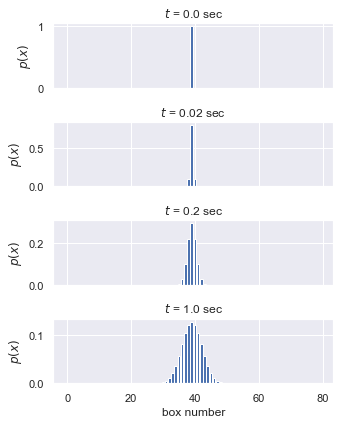

In [11]:
# Determine the number of time points.
time_points = [0, 1,10, 50]

# Define the array of boxes.
bins = np.arange(0, num_boxes, 1)

# Set up the figure. This will return the same number of axes as we 
# have time points.
fig, ax = plt.subplots(nrows=len(time_points), ncols=1, sharex=True,
                      figsize=(5, 6))

# Loop through the time points and make the bar plot.
for i in range(len(time_points)):
    ax[i].bar(bins, prob[:, time_points[i]])
    
    # Set a title so we know the time point and convert it to seconds.
    ax[i].set_title('$t$ = %s sec' %(time_points[i] * dt))
    ax[i].set_ylabel('$p(x)$')
    
# Add an xlabel and clean up the plot.
ax[-1].set_xlabel('box number')

# This command will automatically adjust the spacing between plots to make things
# more aesthetically pleasing.
plt.tight_layout() 

We can see that as we defined, the entire probability at t=0 is located within the middle of the box. However, just one time point later, we can see that there is now non-zero probability at being to the left or right of where we started. By ten time steps, we can see that the distribution is broadening significantly. By 100 steps, the profile looks very Gaussian.

Here, we took just a few slices of the time evolution. To get a more refine picture of how it is broadening, we can look at the entire trace in 3D as a bar plot where $x$ is position, $y$ is time, and $z$ is probability. This can be a bit hard to code, so I've taken the liberty of writing a function for you that will generate this plot. To get the function, download the [`cbbtn_utilities.py`](cbbtn_utilities.py) file and place it in your root working directory. Within this file is a  function called `bar_plot`. Let's take a look at what arguments it takes:

In [13]:
cb.bar_plot?

Signature: cb.bar_plot(data, n_slices, dx=1, dy=1, z_max=1, x_label='x', y_label='y', z_label='z', elev_angle=30, azim_angle=115)
Docstring:
Makes a 3d bar plot of the data given as a 2d numpy array.

Parameters
----------
data: 2d-array
    Two-dimensional numpy array of z-values
n_slices: int
    Number of 'slices' in y-directions to be used in the 3D plot
dx: float
    Distance between neighboring x-positions
dy: float
    Distance between neighboring y-positions
x_label: str
    Label of the x-axis
y_label: str
    Label of the y-axis
z_lable: str
    Label of the z-axis
elev_angle: int
    Alevation viewing angle
azim_angle: int
    Azimuthal viewing angle
z_max: float
    Default limit to the z-axis

Returns
-------
fig: pyplot figure object
    Figure of the 3d-plot

ax: pyplot axes object
    Axes object that contains the figure elements
File:      ~/Dropbox/git/courses/cbbtn/code/cbbtn_utilities.py
Type:      function


All we have to give this function is our matrix of probabilities, information about the step sizes (in time and in position), as well as the relevant angles. Let's give it a shot. 

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x1c1ee257f0>)

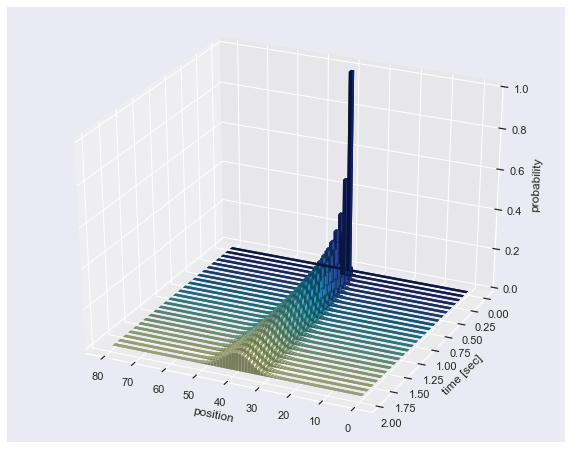

In [17]:
# Generate the 3D bar plot. 
cb.bar_plot(prob, 25, dx=1, dy=dt, x_label='position', 
            y_label='time [sec]', z_label='probability')

Alright, so this lets us see a little more clearly how the distribution evolves with time. If we were to allow this to run even longer, we would see that it would eventually spread to fill the whole box. Rather than letting this run forever, we can run the integration again with a smaller box. Let's redefine the parameters and let the integration run again.

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x1c22b332e8>)

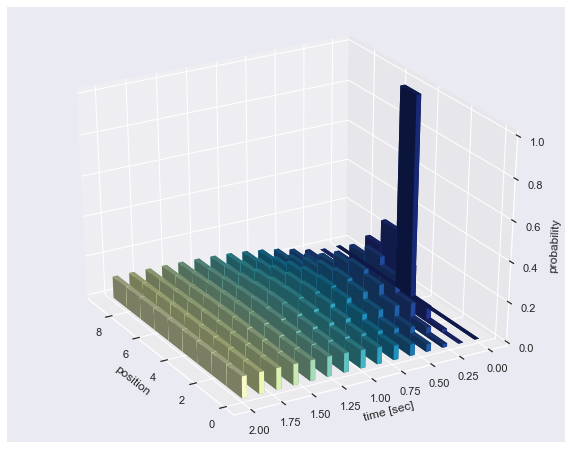

In [32]:
# Set the new box size and set the initial position.
num_boxes = 9 
prob = np.zeros((num_boxes, time_steps))
prob[4, 0] = 1.0

# Run the integration in our new narrow box. 
prob = master_equation(prob, k, dt)

# Generate the bar plot.
cb.bar_plot(prob, 14, dx=1, dy=dt, x_label='position', 
            y_label='time [sec]', z_label='probability',
            azim_angle=150)

Here, I changed the viewing angle to 150 so we can more clearly see what happened at the end. We see that by 1 second, we've completely filled the box where each position has an equal probability. 

This is all with the initial probability being in a single position right inthe middle of the box. What would happen if we changed our initial condition to be somewhere other than the center?


(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x1c230b8978>)

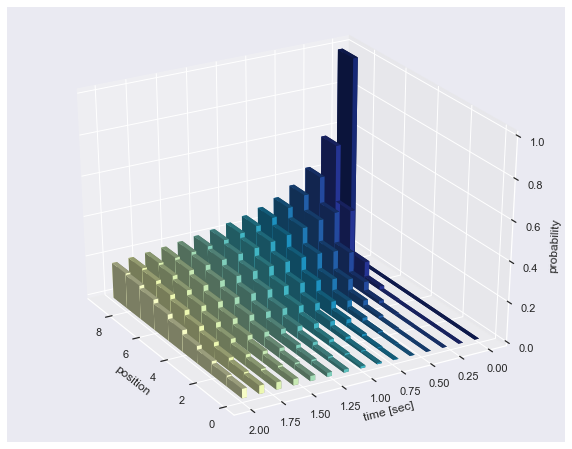

In [34]:
# Reset the box size and probability matrix
num_boxes = 9 
prob = np.zeros((num_boxes, time_steps))

# Set the new initial position
prob[-1, 0] = 1.0

# Run the integration with our new initial position
prob = master_equation(prob, k, dt)

# Generate the bar plot.
cb.bar_plot(prob, 14, dx=1, dy=dt, x_label='position', 
            y_label='time [sec]', z_label='probability',
            azim_angle=150)

Again, this follows (more or less) our intuition. As time goes on, the distribution spreads out, eventually reaching the end of the box. Notice here, that 2 seconds *isn't* enough to completely fill the box where each position has equal probability. 

##  The Annoying (Yet Useful) Process of Photobleaching

However, fluorescent proteins are not fluorescent forever. All fluorescent molecules can undergo a process known as [photobleaching](https://en.wikipedia.org/wiki/Photobleaching) where sustained excitation can lead to the permanent chemical inactivation of the fluorophore. While this is a process that is true for all fluorescent molecules, fluorescent proteins are particularly susceptible to this phenomenon.

While this can be an annoying phenomenon to correct for in your experiment, others have found ways to turn lemons into lemonade and use photobleaching as an experimental tool. A fantastic example of this use is an experimental method named [Fluorescence Recovery After Photobleaching](https://en.wikipedia.org/wiki/Fluorescence_recovery_after_photobleaching), or FRAP for short. This method allows us to make measurements of how mobile a particular molecular species is in a cell. This is commonly used for making mobility measurements of proteins within the cell membrane.

The general scheme of a FRAP experiment is as follows:

1). Attach a fluorescent dye or protein to your molecule of interest. If this is something like a membrane protein, you would imagine that the fluorescence of the membrane would now be relatively uniform in space if there isn't any complicated localization.

2). Illuminate a small section of your field of view with a high-power laser to photobleach all of the fluorescent molecules. All of the molecules outside of this small section will still be fluorescent, but there will now be a "hole" where there is no fluorescence.

3). Take a series of images over time and measure the rate at which the hole becomes fluorescent again. This return of fluorescence is not reactivation of the bleached molecules, however. This is due to the nearby fluorescent molecules diffusing into the hole.

An example of this can be seen below. In 2010, [Nate Goehring](https://goehringlab.crick.ac.uk/) from the Francis Crick Institute published a [beautiful paper](https://goehringlab.crick.ac.uk/biophysicaljournal2010goehr.pdf) performing a detailed quantitative analysis of FRAP measurements and examined the diffusion rate of fluorescent molecules within a *C. elegans* cell membrane as well as the diffusion rate between the cell cytoplasm and the membrane. The authors examined multiple geometries of bleaching patterns and wrote some open source software that is meant to aid others in performing this type of rigorous experiment.

Figure 1 of this paper shows a representative FRAP experiment and the quantified fluorescence at the beginning and end of the movie.

![](goehring_2010.png)

The astute observer will realize that we can simulate this experiment by integrating Eq. 1 with a special initial condition. To set the intial condition, we'll set the probability equal across all of the boxes save for a few right in the middle which will serve as our photobleached "hole". Let's give it a shot.

In [58]:
# Set the box dimensions
num_boxes = 20
time_steps = 500
prob = np.zeros((num_boxes, time_steps))

# Set the initial condition. We'll leave 6 boxes in the middle empty 
bleach_size = 6
prob[:,0] = 1 / (num_boxes - bleach_size) 

# Set the region where we bleached equal to zero. 
prob[7:13, 0] = 0

# Integrate!
prob = master_equation(prob, k, dt)


Now, let's take a look at the time evolution to see how the fluorescent molecules diffused into the hole from the adjacent boxes.

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x1c2758a0b8>)

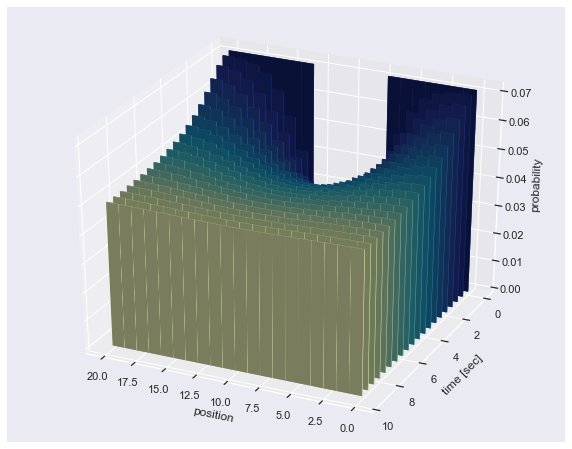

In [59]:
cb.bar_plot(prob, 20, dx=1, dy=dt, x_label='position', 
            y_label='time [sec]', z_label='probability')
          


Now we can see that the hole we bleached in our simulated membrane is filling up as molecules diffuse in from the left and right. You should also notice that the height of the bars on the extreme left and right side are decreasing. If we were to think of the height of these bars as a measure of fluorescence, this translates to a decrease in fluorescence of the nearby boxes as the hole is filled.

## In Conclusion... 

In this tutorial, we've learned another way to computationally explore the process of diffusion as well as an introduction to a very powerful experimental method. Now that you've been exposed to chemical master equations, we can begin to think about various other biological processes through this determinstic lens. In the coming days, we'll take this approach to dissect transcription and the distribution of mRNA. 